In [542]:
# fix annoying bug
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [543]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [544]:
cuda_id = torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce GTX 1070 Ti'

In [545]:
data_transform = transform=torchvision.transforms.Compose([
        ToTensor(),
        # Lambda(lambda x: x.squeeze())  # Squeezes the 1D channel dimension - the score network has this dimension included hence commented
    ])
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

In [546]:
len(training_data), len(test_data)

(60000, 10000)

In [547]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [548]:
T = 1000
beta = torch.linspace(1e-4,0.02,T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

In [549]:
IMAGE_SHAPE = torch.tensor(training_data[0][0].shape)
IMAGE_SHAPE

tensor([ 1, 28, 28])

torch.Size([1, 28, 28])


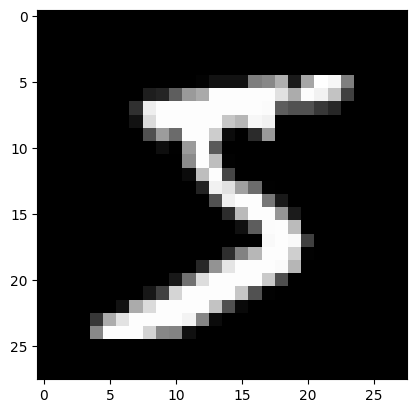

TypeError: 'int' object is not subscriptable

In [550]:
def forward_diffusion(x0, t):
    t = t[...,None,None]
    eps = torch.normal(mean=0, std=torch.ones(x0.shape)).to(device)
    xt = alpha_bar[t]**0.5 * x0 + (1 - alpha_bar[t])**0.5 * eps
    return xt, eps

x0 = training_data[0][0].to(device)
print(x0.shape)
plt.imshow(np.squeeze(x0.cpu()),cmap='gray')
plt.show()

# xt, eps = forward_diffusion(x0, T//10)
# print(xt.shape)
# plt.imshow(np.squeeze(xt.cpu()),cmap='gray')
# plt.show()

In [ ]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        if signal.isnan().any():
            print('nans!!!')
        return signal

model = ScoreNetwork0().to(device)

In [ ]:
loss_fn = torch.nn.MSELoss()

In [ ]:
x = torch.ones((2,3))
y = torch.zeros((2,3))
loss_fn(x,y)

tensor(1.)

In [ ]:
ts = torch.randint(low=0, high=T-1, size=(3,))
alpha[ts]**0.5

tensor([0.9907, 0.9955, 0.9903], device='cuda:0')

In [ ]:
torch.normal(mean=alpha[ts], std=0.0)

tensor([0.9815, 0.9911, 0.9808], device='cuda:0')

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        cur_batch_size = X.shape[0]
        X = X.to(device)
        t = torch.randint(low=0, high=T-1, size=(cur_batch_size,1), device=device)
        Xt, eps = forward_diffusion(X, t)
        Xt = Xt.reshape(cur_batch_size, -1)

        # Compute prediction and loss
        pred = model(Xt, t)
        loss = loss_fn(pred.reshape(cur_batch_size, *IMAGE_SHAPE), eps)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
        # if batch % 5 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            # loss, current = loss.item() / cur_batch_size, batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

In [ ]:
learning_rate = 1e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [552]:
 # Training
epochs = 10
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)  # not done
print("Done!")

Epoch 1
-------------------------------
loss: 0.224314  [   64/60000]
loss: 0.046462  [ 6464/60000]
loss: 0.046426  [12864/60000]
loss: 0.046149  [19264/60000]
loss: 0.039205  [25664/60000]
loss: 0.056217  [32064/60000]
loss: 0.040749  [38464/60000]
loss: 0.042208  [44864/60000]
loss: 0.038477  [51264/60000]
loss: 0.038782  [57664/60000]
Epoch 2
-------------------------------
loss: 0.033933  [   64/60000]
loss: 0.040500  [ 6464/60000]
loss: 0.030512  [12864/60000]
loss: 0.039527  [19264/60000]
loss: 0.031135  [25664/60000]
loss: 0.035344  [32064/60000]
loss: 0.035815  [38464/60000]
loss: 0.042437  [44864/60000]
loss: 0.042075  [51264/60000]
loss: 0.026045  [57664/60000]
Epoch 3
-------------------------------
loss: 0.044369  [   64/60000]
loss: 0.035112  [ 6464/60000]
loss: 0.057414  [12864/60000]
loss: 0.045570  [19264/60000]
loss: 0.052385  [25664/60000]
loss: 0.044050  [32064/60000]
loss: 0.040606  [38464/60000]
loss: 0.062220  [44864/60000]
loss: 0.025309  [51264/60000]
loss: 0.02

In [553]:
def sampling():
    sig = beta**0.5
    x = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
    for t in range(T-1, -1, -1):
        if t > 0:
            z = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
        else:
            z = torch.zeros(*IMAGE_SHAPE).to(device)
        t = torch.tensor([t]).to(device)
        eps_theta = model(x.flatten(), t).reshape(*IMAGE_SHAPE)
        x = 1/alpha[t]**0.5 * (x - (1-alpha[t])/(1-alpha_bar[t])**0.5 * eps_theta) + \
                sig[t] * z
    
    return x.detach()

In [559]:
x_sample = sampling()
# x_sample

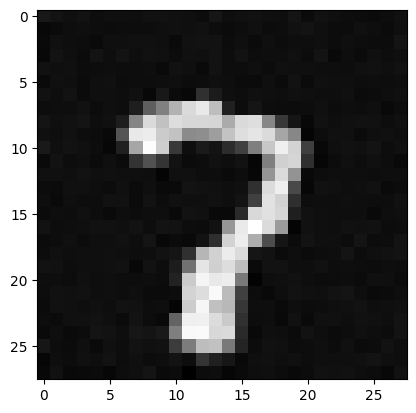

In [560]:
plt.imshow(np.squeeze(x_sample.cpu()), cmap='gray')